In [1]:
!pip install gymnasium[atari] --quiet
!pip install gymnasium --quiet
!pip install -U gymnasium[atari] --quiet
!pip install imageio_ffmpeg --quiet
!pip install npy_append_array --quiet
!pip install pyTelegramBotAPI --quiet
!pip install gymnasium[accept-rom-license] --quiet
!pip install gymnasium[box2d] --quiet

In [4]:
!git clone https://github.com/openai/multiagent-particle-envs.git
!pip install -e .
!pip install gym==0.10.5

Obtaining file:///kaggle/working/multiagent-particle-envs
  Preparing metadata (setup.py) ... done
  Running setup.py develop for multiagent
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 27.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.3/831.3 kB 54.0 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.10.5-py3-none-any.whl size=1581305 sha256=0bdceaaaed32fbfb075b74562c575283c85ac60e85069a01ea85912daca2c5d5
  Stored in directory: /root/.cache/pip/wheels/08/2b/10/75863142f91b7eae8a37471c71f078ad1c88373ae8c481869c
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.23.1
    Uninstalling gym-0.23.1:
      Successfully uninstalled gym-0.23.1


In [5]:
import numpy as np

class MultiAgentReplayBuffer:
    def __init__(self, max_size, env_obs_dims, actor_dims, 
                                        n_actions, n_agents, batch_size):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.n_agents = n_agents
        self.actor_dims = actor_dims
        self.batch_size = batch_size
        self.n_actions = n_actions

        self.env_obs_memory = np.zeros((self.mem_size, env_obs_dims))
        self.env_next_obs_memory = np.zeros((self.mem_size, env_obs_dims))
        self.reward_memory = np.zeros((self.mem_size, n_agents))
        self.terminal_memory = np.zeros((self.mem_size, n_agents), dtype=bool)

        self.init_actor_memory()

    def init_actor_memory(self):
        self.actors_state_memory = []
        self.actors_new_state_memory = []
        self.actors_action_memory = []

        for i in range(self.n_agents):
            self.actors_state_memory.append(
                            np.zeros((self.mem_size, self.actor_dims[i])))
            self.actors_new_state_memory.append(
                            np.zeros((self.mem_size, self.actor_dims[i])))
            self.actors_action_memory.append(
                            np.zeros((self.mem_size, self.n_actions)))


    def store_experiences(self, actor_states, env_obs, actors_actions, reward, 
                                                   actor_next_states, env_next_obs, done):

        index = self.mem_cntr % self.mem_size

        for agent_idx in range(self.n_agents):
            self.actors_state_memory[agent_idx][index] = actor_states[agent_idx]
            self.actors_new_state_memory[agent_idx][index] = actor_next_states[agent_idx]
            self.actors_action_memory[agent_idx][index] = actors_actions[agent_idx]

        self.env_obs_memory[index] = env_obs
        self.env_next_obs_memory[index] = env_next_obs
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_experiences(self):
        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, self.batch_size, replace=False)

        env_obs = self.env_obs_memory[batch]
        rewards = self.reward_memory[batch]
        env_next_obs = self.env_next_obs_memory[batch]
        terminal = self.terminal_memory[batch]

        actor_states = []
        actor_new_states = []
        actors_actions = []
        for agent_idx in range(self.n_agents):
            actor_states.append(self.actors_state_memory[agent_idx][batch])
            actor_new_states.append(self.actors_new_state_memory[agent_idx][batch])
            actors_actions.append(self.actors_action_memory[agent_idx][batch])
        
        #actor_states, actor_new_states, actors_actions = np.array(actor_states), np.array(actor_new_states), np.array(actors_action)
        return actor_states, env_obs, actors_actions, rewards, \
               actor_new_states, env_next_obs, terminal

    def is_sufficient(self):
        if self.mem_cntr >= self.batch_size:
            return True

In [6]:
import tensorflow as tf 
from tensorflow.keras.layers import Dense, Conv2D, Input, Lambda, concatenate
 
class ActorNetwork(tf.keras.Model):
    def __init__(self, actor_input_dims, action_dims):
        super(ActorNetwork, self).__init__()
        self.fc1 = Dense(64, activation="relu", input_shape=(actor_input_dims, ), kernel_initializer="he_uniform")
        self.fc2 = Dense(32, activation="relu", kernel_initializer="he_uniform")
        self.fc3 = Dense(32, activation="relu", kernel_initializer="he_uniform")
        
        self.out = Dense(action_dims, activation='softmax')

    def call(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.out(x)
        return x 


class CriticNetwork(tf.keras.Model):
    def __init__(self, critic_input_dims, action_dims): 
        super(CriticNetwork, self).__init__()
        self.fc1 = Dense(64, activation="relu", kernel_initializer="he_uniform", input_shape=(critic_input_dims, ))
        self.fc2 = Dense(32, activation="relu", kernel_initializer="he_uniform")
        self.fc3 = Dense(32, activation="relu", kernel_initializer="he_uniform")
        self.out = Dense(1, activation='linear')

    def call(self, state, action):
        x = self.fc1(tf.concat([state, action], axis=1))
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.out(x)
        return x 

In [7]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf 
import tensorflow_probability as tfp
import numpy as np

class DDPGAgent:
  
    def __init__(self, actor_input_dims, critic_input_dims, n_actions, alpha, beta, soft_update, tau): 
        self.tau = tau 
        self.soft_update = soft_update
        self.fname = "models/"

        self.actor = ActorNetwork(actor_input_dims, n_actions)
        self.target_actor = ActorNetwork(actor_input_dims, n_actions)
        self.critic = CriticNetwork(critic_input_dims, 1)
        self.target_critic = CriticNetwork(critic_input_dims, 1)
        
        self.actor.compile(optimizer=Adam(learning_rate=alpha))
        self.critic.compile(optimizer=Adam(learning_rate=beta))
        self.target_actor.compile(optimizer=Adam(learning_rate=alpha))
        self.target_critic.compile(optimizer=Adam(learning_rate=beta))

        self.update_target_networks()
        
    def ou_noise(self, x, rho=0.15, mu=0, dt=1e-1, sigma=0.2, dim=1):
        return x + rho * (mu-x) * dt + sigma * np.sqrt(dt) * np.random.normal(size=dim)
        
    def get_action(self, state): 
        state = tf.convert_to_tensor(state, dtype=tf.float32)
        state = tf.reshape(state, (1, state.shape[0]))
        
        actions = self.actor(state)
        noise = tf.random.normal([n_actions])
        action = actions + noise

        return action.numpy()[0]
 
    def save_models(self, no):
        self.actor.save(self.fname + f"maddpg_actor_{no}")
        self.target_actor.save(self.fname + f"maddpg_target_actor_{no}")
        self.critic.save(self.fname  + f"maddpg_critic_{no}")
        self.target_critic.save(self.fname  + f"maddpg_target_critic_{no}")
        print("[+] Saving the models") 

    def load_models(self, no):
        self.actor = tf.keras.models.load_model(self.fname  + f"madddpg_actor_{no}") 
        self.target_actor = tf.keras.models.load_model(self.fname + f"maddpg_target_actor_{no}") 
        self.critic = tf.keras.models.load_model(self.fname +  f"maddpg_critic_{no}") 
        self.target_critic = tf.keras.models.load_model(self.fname + f"maddpg_target_critic_{no}") 
        print("[+] Loading the models")
  
    
    def update_target_networks(self):
        actor_weights = self.actor.get_weights()
        t_actor_weights = self.target_actor.get_weights()
        critic_weights = self.critic.get_weights()
        t_critic_weights = self.target_critic.get_weights()
        if self.soft_update: 
            for i in range(len(actor_weights)):
                t_actor_weights[i] = self.tau * actor_weights[i] + (1 - self.tau) * t_actor_weights[i]

            for i in range(len(critic_weights)):
                t_critic_weights[i] = self.tau * critic_weights[i] + (1 - self.tau) * t_critic_weights[i]

            self.target_actor.set_weights(t_actor_weights)
            self.target_critic.set_weights(t_critic_weights)
            
        else: 
            self.target_actor.set_weights(t_actor_weights)
            self.target_critic.set_weights(t_critic_weights)
  

In [8]:
class MADDPGAgent: 
    def __init__(self, actors_input_dims, critic_input_dims, batch_size, 
                                         n_agents, n_actions, tau, alpha, beta, soft_update, gamma): 
        self.actors_input_dims = actors_input_dims
        self.critic_input_dims = critic_input_dims
        self.n_agents = n_agents 
        self.n_actions = n_actions 
        self.tau = tau 
        self.gamma = gamma
        self.alpha = alpha 
        self.beta = beta
        self.soft_update = soft_update
        self.batch_size = batch_size
        
        self.ddpg_agents = []
        
        
    def initialize_agents(self): 
        for i in range(self.n_agents): 
            actor_input_dims = self.actors_input_dims[i]
            critic_input_dims = self.critic_input_dims + self.n_actions * self.n_agents
            agent = DDPGAgent(actor_input_dims, critic_input_dims, self.n_actions, 
                                              self.alpha, self.beta, self.soft_update, self.tau)
            
            self.ddpg_agents.append(agent)
            
            
    def get_actions(self, actors_state): 
        actions = []
        for agent_indx, agent in enumerate(self.ddpg_agents): 
            actor_state = actors_state[agent_indx]
            action = agent.get_action(actor_state)
            actions.append(action)
        
        return actions 
    
    
    def learn(self, env_obs, env_nxt_obs, actors_states, 
                              actors_nxt_state, actions, rewards, dones): 
        
        env_obs = tf.convert_to_tensor(env_obs, dtype=tf.float32)
        env_nxt_obs = tf.convert_to_tensor(env_nxt_obs, dtype=tf.float32)
        rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)        
        dones = tf.convert_to_tensor(dones, dtype=tf.bool)
        actions = tf.convert_to_tensor(actions, dtype=tf.float32)
        
        
        all_agents_new_actions = []
        all_agents_new_mu_actions = []
        old_agents_actions = []

        for agent_idx, agent in enumerate(self.ddpg_agents):
            new_states = tf.convert_to_tensor(actors_nxt_state[agent_idx], dtype=tf.float32)

            new_pi = agent.target_actor(new_states)
            all_agents_new_actions.append(new_pi)
            old_agents_actions.append(actions[agent_idx])

        next_actions = tf.concat([acts for acts in all_agents_new_actions], axis=1)
        old_actions = tf.concat([acts for acts in old_agents_actions], axis=1)
        
        for agent_idx, agent in enumerate(self.ddpg_agents):
            
            with tf.GradientTape() as tape: 
                next_obs_critic_value = agent.target_critic(env_nxt_obs, next_actions)
                next_obs_critic_value = tf.squeeze(next_obs_critic_value)

                next_obs_critic_value = tf.where(dones[:, 0], 0.0, next_obs_critic_value)

                curr_obs_critic_value = agent.critic(env_obs, old_actions)
                curr_obs_critic_value = tf.squeeze(curr_obs_critic_value)

                target = rewards[:, agent_idx] + self.gamma*next_obs_critic_value
                critic_loss = self.critic_loss(curr_obs_critic_value, target)
            
            critic_params = agent.critic.trainable_variables
            critic_grads = tape.gradient(critic_loss, critic_params)
            
            agent.critic.optimizer.apply_gradients(zip(critic_grads, critic_params))
            
            with tf.GradientTape() as tape: 
                all_agents_new_mu_actions = []
                for agent_idx, agent in enumerate(self.ddpg_agents): 
                    mu_states = tf.convert_to_tensor(actors_states[agent_idx])
                    pi = agent.actor(mu_states)
                    all_agents_new_mu_actions.append(pi)
                mu = tf.concat([acts for acts in all_agents_new_mu_actions], axis=1)
                
                q_value = agent.critic(env_obs, mu)
                q_value = tf.squeeze(q_value)
                actor_loss = self.actor_loss(q_value)
            
            actor_params = agent.actor.trainable_variables
            actor_grads = tape.gradient(actor_loss, actor_params)
            
            agent.actor.optimizer.apply_gradients(zip(actor_grads, actor_params))
            
            agent.update_target_networks()
        
        
    def save_models(self):
        for agent_indx, agent in enumerate(self.ddpg_agents): 
            agent.save_models(agent_indx)
    
    def load_models(self):
        pass
    
    def critic_loss(self, q_value, target_q_value): 
        mse = tf.keras.losses.MeanSquaredError()
        loss = mse(target_q_value, q_value)
        
        return loss
    
    def actor_loss(self, q_value):
        return -tf.reduce_mean(q_value)

In [9]:
import time
from telebot import TeleBot
import datetime
import telebot

token = "6238487424:AAG0jRhvbiVa90qUcf2fAirQr_-quPMs7cU"
chat_id = "1055055706"
bot = TeleBot(token=token) 

def telegram_send(message, bot):
    chat_id = "1055055706"
    bot.send_message(chat_id=chat_id, text=message)

def welcome_msg(multi_step, double_dqn, dueling):
    st = 'Hi! Starting learning with DQN Multi-step = %d, Double DQN = %r, Dueling DQN = %r' % (multi_step, double_dqn, dueling)
    telegram_send(st, bot)
    
def info_msg(episode, max_episode, reward, best_score, loss): 
    st = f"Current Episode: {episode}, Current Reward: {reward}, Max Episode: {max_episode}, Best Score: {best_score}, loss: {loss}"
    telegram_send(st, bot)

def end_msg(learning_time):
    st = 'Finished! Learning time: ' + str(datetime.timedelta(seconds=int(learning_time)))
    telegram_send(st, bot)
    print(st)

In [10]:
import collections
import cv2
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import tensorflow as tf
from gymnasium.wrappers import *


def manage_memory():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print(e)


def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 100 scores')
    plt.savefig(figure_file)


def make_env(env_name, video_file_name, episode_freq_fo_video): 
    env = gym.make(env_name, render_mode="rgb_array")
    
    if len(env.observation_space.shape) >= 3: 
        #env = AtariPreprocessing(env, 10, 4, 84, False, True)
        env = ResizeObservation(env, 84)
        env = GrayScaleObservation(env, keep_dim=False)
        env = FrameStack(env, 4, lz4_compress=False)
        env = NormalizeObservation(env)

    return env

In [11]:
class Writer:
    def __init__(self, fname): 
        self.fname = fname 

    def write_to_file(self, content): 
        with open(self.fname, "a") as file: 
            file.write(content + "\n")

    def read_file(self, fname):
        with open(fname, "r") as file: 
            return file.read()
            

In [12]:
import numpy as np 
import imageio


class RecordVideo: 
    
    def __init__(self, prefix_fname,  out_directory="videos/", fps=10): 
        self.prefix_fname = prefix_fname
        self.out_directory = out_directory
        self.fps = fps
        self.images = []
        
    def add_image(self, image): 
        self.images.append(image)
    
    def save(self, episode_no): 
        name = self.out_directory + self.prefix_fname + "_" + str(episode_no) + ".mp4"
        imageio.mimsave(name, [np.array(img) for i, img in enumerate(self.images)], fps=self.fps)
        self.images = []

In [13]:
from npy_append_array import NpyAppendArray
import numpy as np

class Trainer:   
    def __init__(self, env, gamma, alpha, beta, tau, soft_update, 
                                 noe, max_steps, is_tg, tg_bot_freq_epi, record, 
                                 env_obs_dims, actors_input_dims, n_agents, n_actions, batch_size, mem_size): 
        self.env = env 
        self.target_score = 80
        self.noe = noe
        self.max_steps = max_steps
        self.is_tg = is_tg
        self.tg_bot_freq_epi = tg_bot_freq_epi
        self.record = record 
        self.writer = Writer("model_training_results.txt")
        self.recorder = RecordVideo("maddpg", "videos/", 20)
        self.maddpg_agent = MADDPGAgent(actors_input_dims, env_obs_dims, batch_size, n_agents, 
                                             n_actions, tau, alpha, beta, soft_update, gamma)
        
        self.maddpg_agent.initialize_agents()
        print(env_obs_dims, "en")
        self.memory = MultiAgentReplayBuffer(mem_size, env_obs_dims, 
                                                 actors_input_dims, n_actions, n_agents, batch_size)
        
        
    def create_env_obs(self, actors_state): 
        env_obs = np.array([])
        for actor_state in actors_state:
            env_obs = np.append(env_obs, actor_state)

        return np.array(env_obs)

    
    def train_rl_model(self): 
        learned = False
        avg_rewards = []
        best_reward = float("-inf")
        episode_rewards = []
        adversial_rewards = []
        agents_rewards  = []
        tot_steps = 0
        
        for episode in range(self.noe): 
            n_steps = 0 
            adversial_reward = 0
            agent_reward = 0
            actors_state = env.reset()
            reward = 0 
            
            if record and episode % 50 == 0:
                img = self.env.render()
                self.recorder.add_image(img)

            for step in range(self.max_steps): 
                
                actors_actions = self.maddpg_agent.get_actions(actors_state)

                next_info = self.env.step(actors_actions)
                actors_next_state, reward_probs, dones, _ = next_info
          #      print(dones)
                reward += sum(reward_probs)
                
                env_obs = self.create_env_obs(actors_state)
                env_nxt_obs = self.create_env_obs(actors_next_state)

                self.memory.store_experiences(actors_state, env_obs, actors_actions, 
                                                     reward_probs, actors_next_state, env_nxt_obs, dones)
                
                if self.memory.is_sufficient() and tot_steps % 50 == 0: 
                    learned = True
                    actors_states_batch, env_obs_batch, actors_actions_batch, rewards_batch, \
                                actor_new_states_batch, env_next_obs_batch, terminal_batch = self.memory.sample_experiences()
                    

                    self.maddpg_agent.learn(env_obs_batch, env_next_obs_batch, actors_states_batch, 
                                                    actors_actions_batch, actors_actions_batch, rewards_batch, terminal_batch)

                actors_state = actors_next_state
                n_steps += 1   
                tot_steps += 1 
                
                adversial_reward += reward_probs[0]
                agent_reward += sum(reward_probs[0: ])
                
                # record
                if record and episode % 50 == 0:
                    img = self.env.render()
                    self.recorder.add_image(img)
                
                if np.any(dones): 
                    break
            
            episode_rewards.append(reward)
            avg_reward = np.mean(episode_rewards[-100:])
            avg_rewards.append(avg_reward)
            adversial_rewards.append(adversial_reward)
            agents_rewards.append(agent_reward)

            result = f"Episode: {episode}, Steps: {n_steps}, Reward: {reward}, Best reward: {best_reward}, Avg reward: {avg_reward}"
            self.writer.write_to_file(result)
            if episode % 1 == 0: 
                print(result)
            
            # Recording.
            if record and episode % 50 == 0:
                self.recorder.save(episode)
                
            # Saving Best Model
            if reward > best_reward and episode != 0 and learned: 
                best_reward = reward
                self.maddpg_agent.save_models()
                
            # Telegram bot
            if self.is_tg and episode % self.tg_bot_freq_epi == 0: 
                info_msg(episode+1, self.noe, reward, best_reward, "d")
                
            # Eatly Stopping
            if episode > 100 and np.mean(episode_rewards[-20:]) >= self.target_score: 
                break
                
        return episode_rewards, avg_rewards, best_reward, adversial_rewards, agents_rewards
    

/kaggle/working/multiagent-particle-envs/multiagent/__init__.py:23: UserWarning: This code base is no longer maintained, and is not expected to be maintained again in the future. 
For the past handful of years, these environments been maintained inside of PettingZoo (see https://pettingzoo.farama.org/environments/mpe/). 
This maintained version includes documentation, support for the PettingZoo API, support for current versions of Python, numerous bug fixes, 
support for installation via pip, and numerous other large quality of life improvements. 
We encourage researchers to switch to this maintained version for all purposes other than comparing to results run on this version of the environments. 

  warnings.warn("This code base is no longer maintained, and is not expected to be maintained again in the future. \n"


Please read the raised warning, then press Enter to continue... (to suppress this prompt, please set the environment variable `SUPPRESS_MA_PROMPT=1`)
 


<MultiAgentEnv instance>
4
62 en
Episode: 0, Steps: 100, Reward: -241.9076293256305, Best reward: -inf, Avg reward: -241.9076293256305
Episode: 1, Steps: 100, Reward: -60.26172690926498, Best reward: -inf, Avg reward: -151.08467811744774
Episode: 2, Steps: 100, Reward: -899.3038081189139, Best reward: -inf, Avg reward: -400.49105478460314
Episode: 3, Steps: 100, Reward: -558.6535210719582, Best reward: -inf, Avg reward: -440.03167135644185
Episode: 4, Steps: 100, Reward: -290.0082126437586, Best reward: -inf, Avg reward: -410.0269796139052
Episode: 5, Steps: 100, Reward: 0, Best reward: -inf, Avg reward: -341.68914967825435
Episode: 6, Steps: 100, Reward: -62.5901767543242, Best reward: -inf, Avg reward: -301.8178678319786
Episode: 7, Steps: 100, Reward: 68.07893965578292, Best reward: -inf, Avg reward: -255.58076689600844
Episode: 8, Steps: 100, Reward: -3.191409518392839, Best reward: -inf, Avg reward: -227.53750496516227
Episode: 9, Steps: 100, Reward: -400.1405611774159, Best rewar

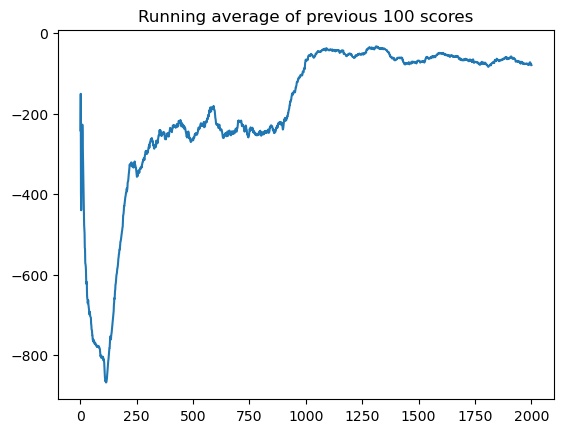

In [14]:
from make_env import make_env
import time
import signal
import time
import sys
import pickle
import os 

scenario = "simple_tag"
env = make_env(scenario)
print(env)
print(env.n)
record = False
gamma = 0.95 # 0.95 in paper 
alpha = 0.0001
beta = 0.001
batch_size = 1024
tau = 0.05
soft_update = False 
noe = 2000
max_steps = 100
is_tg = True 
tg_bot_freq_epi = 20
record = False 
mem_size = 100000

n_agents = env.n


actors_input_dims = [env.observation_space[dim].shape[0] for dim in range(env.n)]
env_obs_dims = sum(actors_input_dims)
n_actions = env.action_space[0].n
    
if __name__ == "__main__": 
    
    try: 
        
        if not os.path.exists("videos"): 
            os.mkdir("videos")

        if not os.path.exists("test_videos"):
            os.mkdir("test_videos")
            
        manage_memory()
        trainer = Trainer(env, gamma, alpha, beta, tau, soft_update, 
                                 noe, max_steps, is_tg, tg_bot_freq_epi, record, 
                                 env_obs_dims, actors_input_dims, n_agents, n_actions, batch_size, mem_size
                         )
        episode_rewards, avg_rewards, best_reward, adversial_rewards, agents_rewards = trainer.train_rl_model()
        
        with open("maddpg_tot_episode_rewards.obj", "wb") as f: 
            pickle.dump(episode_rewards, f)
        
        with open("maddpg_avg_rewards.obj", "wb") as f: 
            pickle.dump(avg_rewards, f)
            
        with open("maddpg_adversial_episode_rewards.obj", "wb") as f: 
            pickle.dump(adversial_rewards, f)
            
        with open("maddpg_agents_episode_rewards.obj", "wb") as f: 
            pickle.dump(agents_rewards, f)
        
        x = [i+1 for i in range(len(episode_rewards))]
        plot_learning_curve(x, episode_rewards, "maddpg_simple_adv")

       # model_path = "models/lunarlander_DQN_q_value/"

        #evaluator = Eval(env, action_space, model_path, "vanilla_dqn_lunarlander", 10)
        #evaluator.test()
        
    except Exception as error: 
        raise error
        
   # eval_model(env, "keras model", "videos/", fps=10)
